In [1]:

import matplotlib.pyplot as plt
#import mediapipe as mp
#import mediapipe.framework.formats.landmark_pb2 as landmark_pb2
import os
from tensorflow.keras import backend as K
from keras.utils import to_categorical
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping

import pandas as pd
import seaborn as sns

2023-08-17 15:41:32.256867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# create dictionary with integer labels (later used for one-hot encoding)

landmarks_folder = "training_3/landmarks/"

label_list = [label for label in os.listdir(landmarks_folder) if label != '.DS_Store']

label_mapping = {}

for code, label in enumerate(sorted(label_list)):
        label_mapping[label] = code
        
label_mapping

{'X': 0, 'crane': 1, 'empty': 2, 'squat': 3, 'stand': 4}

In [3]:
def perturbate_coordinates(coordinates, translation_range=0.1, noise_std=0.1): 
    perturbed_coordinates = []
    for coord in coordinates:
        # Translate the coordinates
        translation = np.random.uniform(-translation_range, translation_range, size=2)
        translated_coord = coord + translation
        
        # Add noise to the translated coordinates
        noise = np.random.normal(0, noise_std, size=2)
        perturbed_coord = translated_coord + noise
        
        perturbed_coordinates.append(perturbed_coord)
    
    return np.array(perturbed_coordinates)

In [4]:
def load_and_augment_landmarks(landmarks_folder, fold_expansion = 0, translation_range=0.05, noise_std=0.01):
    
    X = []
    y = []

    for pose_folder in os.listdir(landmarks_folder):
        if not pose_folder.startswith('.'):
            pose_label = label_mapping.get(pose_folder)  # Use your label mapping
            pose_folder_path = os.path.join(landmarks_folder, pose_folder)

            for file in os.listdir(pose_folder_path):
                if file.endswith('.npy'):
                    landmark_coordinates = np.load(os.path.join(pose_folder_path, file))

                    X.append(landmark_coordinates)
                    y.append(pose_label)

                    for _ in range(fold_expansion):  # x-fold 
                        perturbed_landmarks = perturbate_coordinates(landmark_coordinates, translation_range, noise_std)
                        X.append(perturbed_landmarks)
                        y.append(pose_label)

    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [ ]:
X = []
y = []

# Iterate through each subfolder (pose label)
for pose_folder in os.listdir(landmarks_folder):
    if not pose_folder.startswith('.'):  # Exclude hidden files/folders
        
        pose_label = label_mapping.get(pose_folder)  # Use your label mapping
        
        pose_folder_path = os.path.join(landmarks_folder, pose_folder)
        
        for file in os.listdir(pose_folder_path):
            if file.endswith('.npy'):  
            
                landmark_coordinates = np.load(os.path.join(pose_folder_path, file))
                
                # add 'original landmarks'
                X.append(landmark_coordinates)
                y.append(pose_label)
                
                # Perturbate and store perturbed landmarks for this pose
                for _ in range(1):  # Expand 2-fold
                    perturbed_landmarks = perturbate_coordinates(landmark_coordinates, translation_range=0.05, noise_std=0.01)
                    X.append(perturbed_landmarks)
                    y.append(pose_label)
                
             

X = np.array(X)
y = np.array(y)

X.shape, y.shape           

In [43]:
X, y = load_and_augment_landmarks(landmarks_folder, fold_expansion= 5, translation_range=0.05, noise_std=0.01)

X.shape, y.shape

((900, 12, 2), (900,))

In [45]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((720, 12, 2), (180, 12, 2), (720,), (180,))

In [46]:
# one-hot encode integer labels
y_train_hot = to_categorical(y_train, num_classes=5)
y_val_hot = to_categorical(y_val, num_classes=5)

y_train_hot.shape, y_val_hot.shape

((720, 5), (180, 5))

In [47]:
# Reshape the X array to 2D
def reshape_landmarks(X):
    num_samples, num_landmarks, num_dimensions = X.shape
    X_reshaped = X.reshape(num_samples, num_landmarks * num_dimensions)
    
    return X_reshaped

X_train_flattened = reshape_landmarks(X_train)
X_val_flattened = reshape_landmarks(X_val)

X_train_flattened.shape, X_val_flattened.shape

((720, 24), (180, 24))

In [54]:
# Create a sequential model
model = tf.keras.Sequential()

# Add layers to the model
model.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train_flattened.shape[1],)))
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(units=5, activation='softmax'))

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                1600      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 5)                 165       
                                                                 
Total params: 3845 (15.02 KB)
Trainable params: 3845 (15.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
callback = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', min_delta=0.0001, verbose=1)

In [12]:
K.clear_session()

In [57]:
# Train the model

batch_size = 32
epochs = 1000

history = model.fit(X_train_flattened, y_train_hot, batch_size=batch_size, epochs=epochs, validation_data=(X_val_flattened, y_val_hot), callbacks=[callback])

Epoch 1/1000
23/23 [==============================] - 1s 9ms/step - loss: 1.4828 - accuracy: 0.4028 - val_loss: 1.4065 - val_accuracy: 0.5111
Epoch 2/1000
23/23 [==============================] - 0s 3ms/step - loss: 1.3202 - accuracy: 0.5542 - val_loss: 1.2367 - val_accuracy: 0.5889
Epoch 3/1000
23/23 [==============================] - 0s 2ms/step - loss: 1.1557 - accuracy: 0.7111 - val_loss: 1.0597 - val_accuracy: 0.7167
Epoch 4/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.9633 - accuracy: 0.8208 - val_loss: 0.8538 - val_accuracy: 0.9444
Epoch 5/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.7660 - accuracy: 0.8736 - val_loss: 0.6795 - val_accuracy: 0.8500
Epoch 6/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.6005 - accuracy: 0.9361 - val_loss: 0.5339 - val_accuracy: 0.9833
Epoch 7/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.4766 - accuracy: 0.9889 - val_loss: 0.4320 - val_accuracy: 0.9944
Epoch 

In [58]:
def plot_training_history(history, save_plot=False, plot_filename=None):
    train_accuracy = history.history['accuracy']
    train_loss = history.history['loss']
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_accuracy) + 1)
    df_metrics = pd.DataFrame({'Epoch': epochs,
                               'Training Accuracy': train_accuracy,
                               'Validation Accuracy': val_accuracy,
                               'Training Loss': train_loss,
                               'Validation Loss': val_loss})

    plt.figure(figsize=(10, 5))

    # First y-axis for Accuracy 
    ax1 = sns.lineplot(x='Epoch', y='Training Accuracy', data=df_metrics, color='navy', label='Training Accuracy')
    ax1 = sns.lineplot(x='Epoch', y='Validation Accuracy', data=df_metrics, color='deepskyblue', label='Validation Accuracy')

    # Second y-axis for Loss
    ax2 = ax1.twinx()
    ax2 = sns.lineplot(x='Epoch', y='Training Loss', data=df_metrics, color='darkgreen', label='Training Loss', legend=False)
    ax2 = sns.lineplot(x='Epoch', y='Validation Loss', data=df_metrics, color='lightgreen', label='Validation Loss', legend=False)

    # Set labels for y-axes
    ax1.set_ylabel('Accuracy')
    ax2.set_ylabel('Loss')

    # Set legends for the lines plotted on each axis
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend(lines, labels, loc='center right')

    plt.grid(False)

    plt.title('Training and Validation Accuracy & Loss')
    plt.xlabel('Epoch')

    if save_plot and plot_filename:
        plt.savefig(plot_filename)

    plt.show()


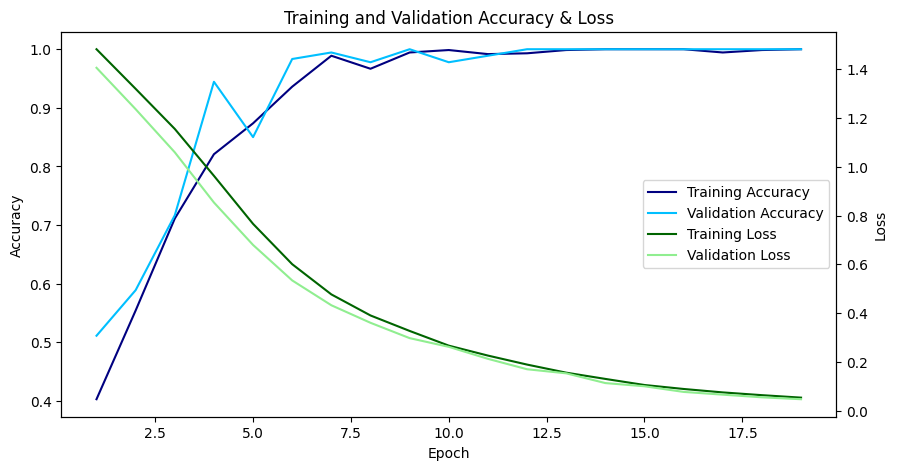

In [59]:
plot_training_history(history, save_plot=True, plot_filename='XXXXX_Loss.png')

In [ ]:
model.save('./models/model_TH_2.h5')

### TEST

In [16]:
def load_and_preprocess_test_data(test_folder):
    X_test = []
    y_test = []

    label_mapping = {}  # Your label mapping here

    for label in os.listdir(test_folder):
        label_folder = os.path.join(test_folder, label)

        if os.path.isdir(label_folder):
            for file_name in os.listdir(label_folder):
                if file_name.endswith('.npy'):
                    data = np.load(os.path.join(label_folder, file_name))
                    X_test.append(data)
                    y_test.append(label_mapping[label])

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_test, y_test

In [17]:
def load_and_preprocess_test_data(test_folder, label_map):
    X_test = []
    y_test = []

    label_mapping = label_map

    for label in os.listdir(test_folder):
        label_folder = os.path.join(test_folder, label)

        if os.path.isdir(label_folder):
            for file_name in os.listdir(label_folder):
                if file_name.endswith('.npy'):
                    data = np.load(os.path.join(label_folder, file_name))
                    X_test.append(data)
                    y_test.append(label_mapping[label])

    X_test = np.array(X_test)
    X_test_flattened = reshape_landmarks(X_test)
    
    y_test = np.array(y_test)

    return X_test_flattened, y_test


In [18]:
test_data_folder = 'test_marco/landmarks'

In [19]:
X_test, y_test = load_and_preprocess_test_data(test_data_folder, label_mapping)

In [20]:
X_test.shape

(62, 24)

In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 [==============================] - 0s 5ms/step


In [22]:
label_mapping

{'X': 0, 'crane': 1, 'empty': 2, 'squat': 3, 'stand': 4}

In [23]:
y_pred_classes

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

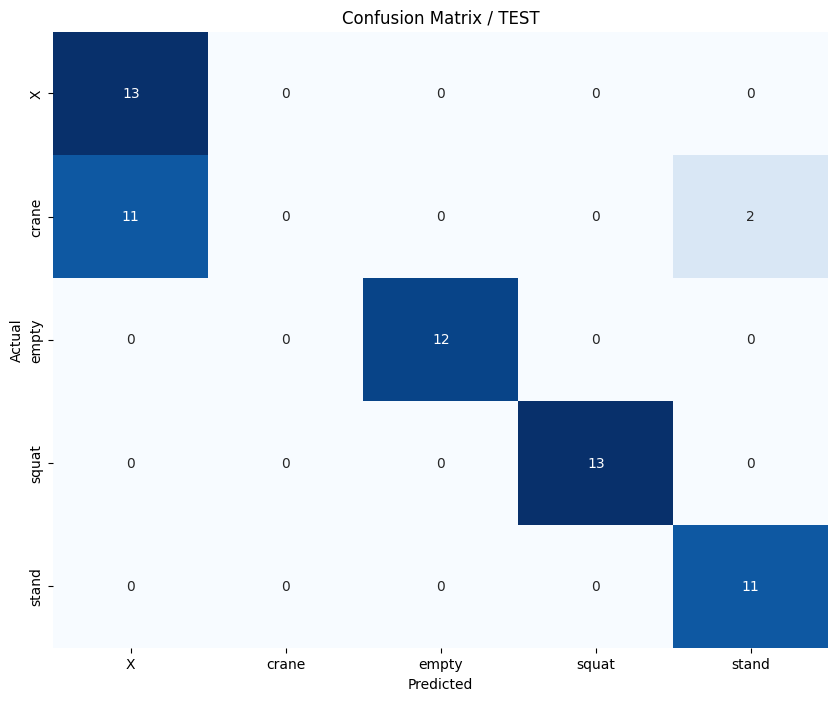

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_classes)

# Get class labels from the label_mapping dictionary
class_labels = [label for label, idx in sorted(label_mapping.items(), key=lambda x: x[1])]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix / TEST')
plt.savefig('cm_1.png')
plt.show()

### Show probabilities

In [ ]:
test_landmarks = 'test_marco/landmarks'

In [ ]:
X_test, _ = load_and_preprocess_test_data(test_landmarks, label_mapping)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
test_pictures = 'test_marco/pictures'

In [ ]:
from PIL import Image

def load_pics(test_folder):
    pic_list = []

    for label in os.listdir(test_folder):
        label_folder = os.path.join(test_folder, label)
        
        if os.path.isdir(label_folder):
            for file_name in os.listdir(label_folder):
                if file_name.endswith('.jpg'):
                    image = Image.open(os.path.join(label_folder, file_name))
                    pic_list.append(image)

    return pic_list

In [ ]:
pic_list = load_pics(test_pictures)

In [ ]:
type(y_pred)

In [ ]:
import os
import numpy as np
from PIL import Image

def load_and_predict_images_and_landmarks(image_folder, landmark_folder, label_map):
    X_images = []
    X_landmarks = []
    y = []

    label_mapping = label_map

    for label in os.listdir(image_folder):
        image_label_folder = os.path.join(image_folder, label)
        landmark_label_folder = os.path.join(landmark_folder, label)

        if os.path.isdir(image_label_folder) and os.path.isdir(landmark_label_folder):
            for image_name in os.listdir(image_label_folder):
                if image_name.endswith('.jpg'):
                    image = Image.open(os.path.join(image_label_folder, image_name))
                    X_images.append(image)

                    landmark_name = image_name.replace('.jpg', '.npy')
                    landmark_path = os.path.join(landmark_label_folder, landmark_name)
                    landmark_data = np.load(landmark_path)
                    X_landmarks.append(landmark_data)

                    y.append(label_mapping[label])

    X_landmarks = np.array(X_landmarks)
    X_landmarks_flattened = reshape_landmarks(X_landmarks)
    
    y = np.array(y)

    return X_images, X_landmarks_flattened, y


label_mapping = label_mapping

# Load images, landmarks, and perform prediction
image_folder = 'test_marco/pictures'
landmark_folder = 'test_marco/landmarks'
X_images, X_landmarks, y_actuals = load_and_predict_images_and_landmarks(image_folder, landmark_folder, label_mapping)


In [ ]:
X_landmarks.shape

In [ ]:
y_pred_test = model.predict(X_landmarks)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

In [ ]:
y_pred_test

In [ ]:
label_mapping

In [ ]:
num_images = len(X_images)

In [ ]:
y_pred.shape

In [ ]:
len(X_images)

In [ ]:
# Plotting
num_results = y_pred.shape[0]
num_columns = 2  # Number of columns (1 for the bar plot, 1 for the image)
subplot_width_ratio = 0.4  # Adjust this value to control the width of the bar plot side
subplot_height = 3  # Adjust this value to control the height of each subplot
num_rows = num_results
fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, num_rows * subplot_height),
                        gridspec_kw={'width_ratios': [subplot_width_ratio, 1-subplot_width_ratio]})

for i in range(num_results):
    ax_bar = axs[i, 0]
    ax_img = axs[i, 1]

    # Get class labels and predicted probabilities for the current result
    class_labels = list(label_mapping.keys())
    class_indices = list(label_mapping.values())
    predicted_probs = y_pred[i]
    actual_label = class_labels[y_actuals[i]]  # Get the actual label based on y_actuals

    # Plot bars for each class
    bars = ax_bar.barh(class_indices, predicted_probs, color='blue')

    # Set y-axis limits to always show 0 to 1 range
    ax_bar.set_xlim(0, 1)

    # Set y-axis labels and ticks
    ax_bar.set_yticks(class_indices)
    ax_bar.set_yticklabels(class_labels)

    # Set x-axis label
    ax_bar.set_xlabel('Predicted Probability')

    # Set bar plot title with actual label
    ax_bar.set_title(f"Result {i + 1} for $\mathbf{{{actual_label}}}$")

    # Display the image
    ax_img.imshow(X_images[i])
    ax_img.axis('off')  # Turn off axis numbers and ticks
    
    ax_bar.axvline(x=0.8, color='red', linestyle='dotted', linewidth=3)

plt.tight_layout()
#plt.savefig('prediction_probs.png')
plt.show()